In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torch import nn
import numpy as np

In [83]:
class ChunkDataset(Dataset):
    def __init__(self, context, next_sentence,Y):
        # Process context sentences and next sentences in batches
        self.context = context
        self.next = next_sentence
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.context[idx], self.next[idx],self.Y[idx]

    def __add__(self, other):
        self.context = torch.cat([self.context, other.context])
        self.next    = torch.cat([self.next, other.next])
        self.Y = torch.cat([self.Y, other.Y])
        
        return self

In [84]:
train_data_path = '../data/data.pkl'
dataset = pd.read_pickle(train_data_path)

In [85]:
from sklearn.model_selection import train_test_split
d_train, d_test =  train_test_split(dataset, test_size=0.2, random_state=42)

In [86]:
context_list = []
next_sentence_list = []
labels_list = []

for (context_embeddings, next_sentence_embeddings,labels) in d_train:
    context_list.append(context_embeddings)
    next_sentence_list.append(next_sentence_embeddings)
    labels_list.append(labels)

context_tensor = torch.vstack(context_list)
next_sentence_tensor = torch.vstack(next_sentence_list)
labels_tensor = torch.tensor(labels_list).type(torch.float)

train_dataset = ChunkDataset(context_tensor,next_sentence_tensor,labels_tensor)

/tmp/ipykernel_31375/3080225995.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y)


In [87]:
context_list = []
next_sentence_list = []
labels_list = []

for (context_embeddings, next_sentence_embeddings,labels) in d_test:
    context_list.append(context_embeddings)
    next_sentence_list.append(next_sentence_embeddings)
    labels_list.append(labels)

context_tensor = torch.vstack(context_list)
next_sentence_tensor = torch.vstack(next_sentence_list)
labels_tensor = torch.tensor(labels_list).type(torch.float)

test_dataset = ChunkDataset(context_tensor,next_sentence_tensor,labels_tensor)

/tmp/ipykernel_31375/3080225995.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y)


In [88]:
train_ratio = 0.8  # 80% of the data for training
dev_ratio = 0.2    # 20% of the data for development

train_size = int(train_ratio * len(train_dataset))
dev_size = len(train_dataset) - train_size

train_subset, dev_subset = random_split(train_dataset, [train_size, dev_size])


In [89]:
batch_size = 2**5
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
dev_loader = DataLoader(dev_subset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [90]:
input_size = d_train[0][0].shape[0]

In [91]:
class ChunkDetector(nn.Module):
    def __init__(self, input_size,hidden_size = 200):
        super().__init__()
        self.hidden_size = torch.tensor(hidden_size).cuda()
        
        self.Potency = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )
        self.Sign = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh()
        )
        self.Value = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, context, sentence):
        context_key     = self.Potency(sentence)    * self.Sign(context)   +  self.Value(context)
        sentence_key    = self.Potency(context)     * self.Sign(sentence)  +  self.Value(sentence)

        context_key     = nn.functional.normalize(context_key, p=2, dim=1)
        sentence_key    = nn.functional.normalize(sentence_key, p=2, dim=1)
        
        similarity = torch.sum(context_key * sentence_key, dim=1)/torch.sqrt(self.hidden_size)
        similarity = self.sigmoid(similarity)
        return similarity
    
model = ChunkDetector(input_size).to("cuda")

In [92]:
# (context,sentence, y) = next(iter(train_loader))
# model(context.cuda(),sentence.cuda())

In [93]:
def train_loop(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0.0  # Accumulate loss over the epoch
    epoch_accuracy = 0.0  # Accumulate accuracy over the epoch

    for batch, (context, sentence, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(context.cuda(), sentence.cuda())
        loss = loss_fn(pred, y.cuda())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # Accumulate loss
        epoch_loss += loss.item()

        # Compute accuracy
        correct = ((pred > 0.5) == y.cuda()).type(torch.float).sum().item()
        epoch_accuracy += correct / len(y)

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / num_batches
    avg_accuracy = epoch_accuracy / num_batches

    return avg_loss, avg_accuracy

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for context, sentence, y in dataloader:
            pred = model(context.cuda(), sentence.cuda()).cpu()
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5) == y).type(torch.float).sum().item()

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / num_batches
    accuracy = correct / size

    return avg_test_loss, accuracy

In [94]:
model = ChunkDetector(input_size).to("cuda")
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
epochs = 50

In [98]:
train_losses = []
train_accuracies = []
dev_losses = []
dev_accuracies = []

smoothing_factor = 0.9

smoothed_dev_accuracy = 0
stable_iterations = 0
patience = 10  # Number of epochs to wait before stopping when accuracy is stable

epoch = 0
while True:
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    
    # Train and evaluate
    avg_train_loss, avg_train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
    avg_dev_loss, avg_dev_accuracy     = test_loop(dev_loader, model, loss_fn)
    
    # Store the results
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    dev_losses.append(avg_dev_loss)
    dev_accuracies.append(avg_dev_accuracy)
    
    # Print the results
    print("Train Loss:  {:.4f},     Train Accuracy: {:.2f}%".format(avg_train_loss, avg_train_accuracy * 100))
    print("Dev Loss:    {:.4f},     Dev Accuracy:   {:.2f}%".format(avg_dev_loss, avg_dev_accuracy * 100))

    # Check if the smoothed dev accuracy is stable
    if abs(smoothed_dev_accuracy - avg_dev_accuracy) < 0.001:
        stable_iterations += 1
    else:
        stable_iterations = 0


    # Calculate exponential smoothing for dev accuracy
    smoothed_dev_accuracy = smoothing_factor * avg_dev_accuracy + (1 - smoothing_factor) * smoothed_dev_accuracy
    
    print("Smoth:       {:.3f},     Stable:         {}".format(smoothed_dev_accuracy * 100, stable_iterations))
    

    
    # Early stopping check
    if stable_iterations >= patience:
        print("Early stopping: dev accuracy is stable.")
        break
    
    epoch += 1


Epoch 1
-------------------------------
Train Loss:  3.8496,     Train Accuracy: 92.50%
Dev Loss:    4.5331,     Dev Accuracy:   90.00%
Smoth:       81.000,     Stable:         0

Epoch 2
-------------------------------
Train Loss:  3.8499,     Train Accuracy: 92.58%
Dev Loss:    4.5336,     Dev Accuracy:   89.83%
Smoth:       88.950,     Stable:         0

Epoch 3
-------------------------------
Train Loss:  3.8497,     Train Accuracy: 92.50%
Dev Loss:    4.5335,     Dev Accuracy:   90.00%
Smoth:       89.895,     Stable:         0

Epoch 4
-------------------------------
Train Loss:  3.8491,     Train Accuracy: 92.54%
Dev Loss:    4.5338,     Dev Accuracy:   89.83%
Smoth:       89.840,     Stable:         1

Epoch 5
-------------------------------
Train Loss:  3.8495,     Train Accuracy: 92.67%
Dev Loss:    4.5330,     Dev Accuracy:   90.00%
Smoth:       89.984,     Stable:         0

Epoch 6
-------------------------------
Train Loss:  3.8493,     Train Accuracy: 92.46%
Dev Loss:  

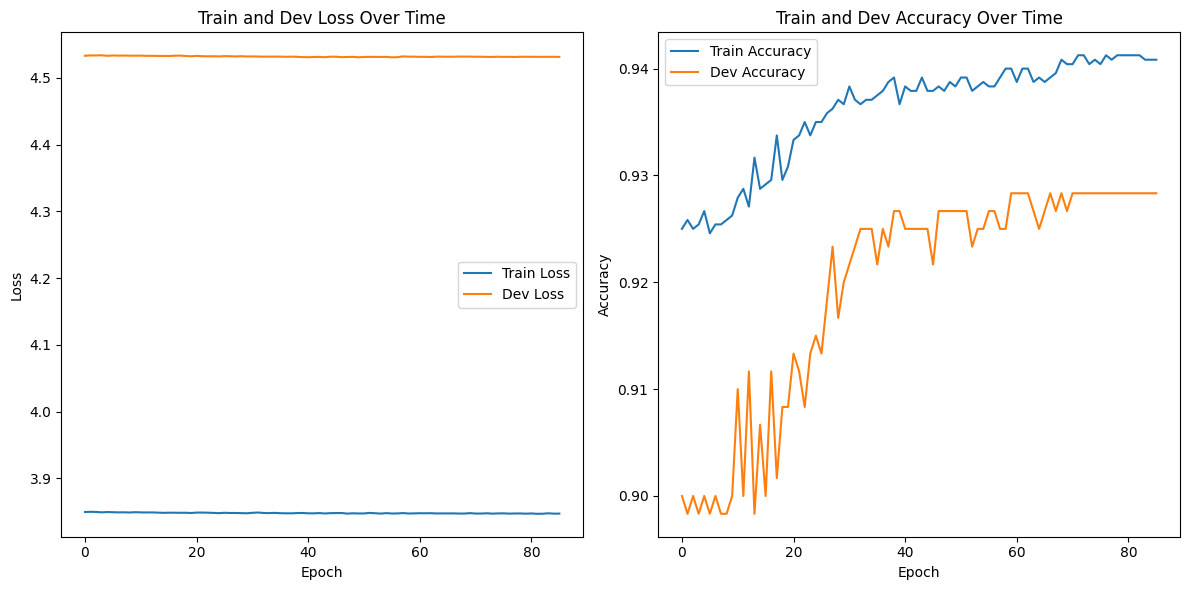

In [99]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(dev_losses, label='Dev Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Dev Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(dev_accuracies, label='Dev Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Dev Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [101]:
for i in range(10):
    avg_train_loss, avg_train_accuracy = train_loop(dev_loader, model, loss_fn, optimizer)

In [102]:
test_loop(test_loader, model, loss_fn)

(2.0098989804585776, 0.9333333333333333)

In [104]:
PATH = "../models/ChunkDetector.ai"
torch.save(model.state_dict(), PATH)

In [105]:
model = ChunkDetector(input_size)
model.load_state_dict(torch.load(PATH))
model.eval()

ChunkDetector(
  (Potency): Sequential(
    (0): Linear(in_features=768, out_features=200, bias=True)
    (1): Sigmoid()
  )
  (Sign): Sequential(
    (0): Linear(in_features=768, out_features=200, bias=True)
    (1): Tanh()
  )
  (Value): Sequential(
    (0): Linear(in_features=768, out_features=200, bias=True)
    (1): ReLU()
  )
  (sigmoid): Sigmoid()
)